In [1]:
!pip install tensorflow keras opencv-python

In [2]:
import tensorflow as tf
import time
from tensorflow.keras import layers, models
import cv2
import numpy as np
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = '/content/drive/MyDrive/machine-learning-project/data/'

In [5]:
def load_tfrecord_dataset(file_path):
    # Define a function to parse the TFRecord file
    feature_description = {
        'image': tf.io.FixedLenFeature([224 * 224 * 1], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_function(example_proto):
        # Parse the input tf.train.Example proto using the feature description
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(parsed_features['image'], [224, 224, 1])
        label = parsed_features['label']
        return image, label

    # Load and parse the dataset
    raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset

# Load the datasets from TFRecord files
ds_train = load_tfrecord_dataset(f'{dir}ds_train.tfrecord')
ds_val = load_tfrecord_dataset(f'{dir}ds_val.tfrecord')
ds_test = load_tfrecord_dataset(f'{dir}ds_test.tfrecord')

In [6]:
for img,label in ds_train.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(2, shape=(), dtype=int64)


In [7]:
for img,label in ds_val.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(0, shape=(), dtype=int64)


In [8]:
for img,label in ds_test.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(0, shape=(), dtype=int64)


In [9]:
# Preprocess the datasets for ResNet
def preprocess_dataset(dataset):
    def refactor(image, label):
        # Convert grayscale images to RGB
        image = tf.image.grayscale_to_rgb(image)
        # Use ResNet preprocessing
        image = tf.keras.applications.resnet.preprocess_input(image)
        return image, label

    dataset = dataset.map(refactor, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Apply preprocessing
ds_train = preprocess_dataset(ds_train)
ds_val = preprocess_dataset(ds_val)
ds_test = preprocess_dataset(ds_test)


In [10]:
# Batch the datasets for training and evaluation
batch_size = 16
ds_train = ds_train.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Load the ResNet model
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers for classification
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(3, activation='softmax')  # Adjust for the number of classes

# Build the model
model = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    dense_layer
])
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20  # Unfreeze the last 20 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Measure training time
start_time = time.time()

# Train the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[early_stopping, lr_scheduler])

# Train the model
#model.fit(ds_train,
#          validation_data=ds_val,
#          epochs=10)
# Measure and print runtime
print(f"Training time: {time.time() - start_time:.2f} seconds")

Epoch 1/20
     85/Unknown 317s 4s/step - accuracy: 0.5668 - loss: 1.1333

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.5673 - loss: 1.1311 - val_accuracy: 0.5294 - val_loss: 4.1623 - learning_rate: 0.0010
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.7488 - loss: 0.6482 - val_accuracy: 0.7353 - val_loss: 0.9094 - learning_rate: 0.0010
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.7992 - loss: 0.4787 - val_accuracy: 0.7176 - val_loss: 0.8715 - learning_rate: 0.0010
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.8952 - loss: 0.2940 - val_accuracy: 0.6765 - val_loss: 1.9913 - learning_rate: 0.0010
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - accuracy: 0.8971 - loss: 0.3012 - val_accuracy: 0.7529 - val_loss: 1.1311 - learning_rate: 0.0010
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.8845 - loss: 0.2969 - val_accuracy: 0.7647 - val_loss: 1.2664 - learning_rate: 0.0010
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.9316 - loss: 0.1653 - val_accuracy: 0.89

In [13]:
# Evaluate the model
eval_results = model.evaluate(ds_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9465 - loss: 0.2811
Test Loss: 0.26281464099884033, Test Accuracy: 0.9470587968826294


In [ ]:
# Export our model to HDF5 file
model.save("HDF5 files/Restnet_Optimization_BreastCancer.h5")


In [15]:
from google.colab import files
files.download("HDF5 files/Restnet_Optimization_BreastCancer.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

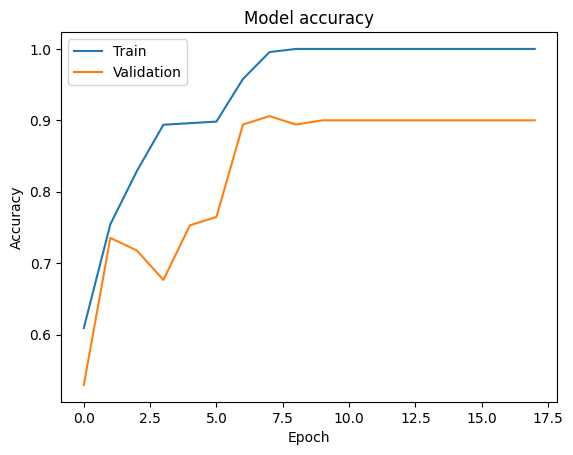

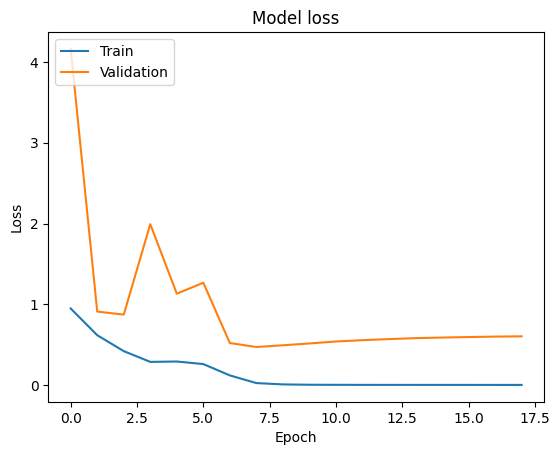

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df_history = pd.DataFrame(history.history)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


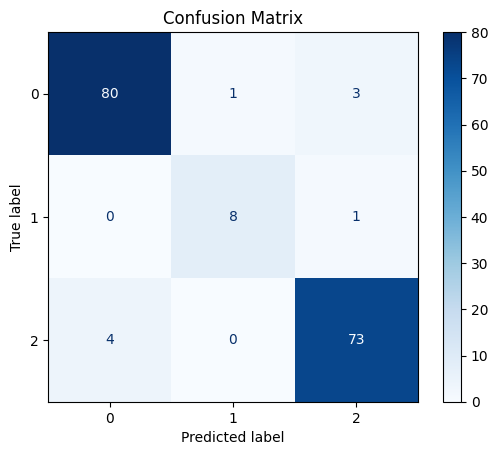

In [18]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

# Get true labels and predicted labels
y_true = []
y_pred = []

# Collect predictions and true labels
for images, labels in ds_test:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(len(cm))],
                     columns=[f"Predicted_{i}" for i in range(len(cm[0]))])

# Save the DataFrame to a CSV file
cm_df.to_csv('/content/confusion_matrix_restnet3.csv', index=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from google.colab import files
files.download('/content/confusion_matrix_restnet3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


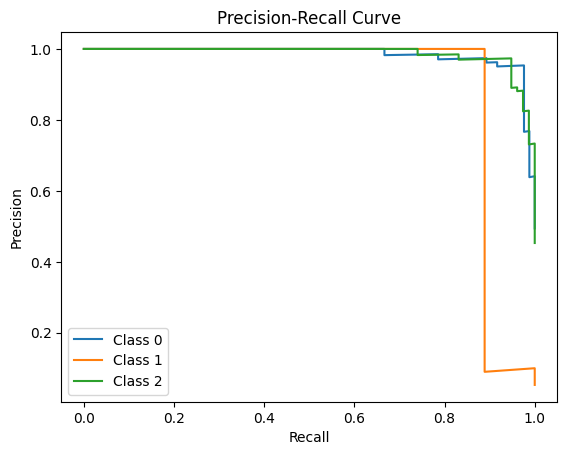

In [26]:
# Precision-Recall Curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import OneHotEncoder

# Assuming y_true contains the true class labels
y_true = np.array(y_true)

# Binarize the true labels (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False)  # Updated argument
y_true_bin = encoder.fit_transform(y_true.reshape(-1, 1))

# Get the predicted probabilities from the model
y_prob = model.predict(ds_test)

# Plot the Precision-Recall Curve for each class
for i in range(3):  # Assuming three classes
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [27]:
# Classification Report

import pandas as pd
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

# Generate the classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('/content/classification_report_restnet3.csv', index=True)

# Check if the file is saved
print("Classification report saved as 'classification_report_restnet3.csv'")

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        84
           1       0.89      0.89      0.89         9
           2       0.95      0.95      0.95        77

    accuracy                           0.95       170
   macro avg       0.93      0.93      0.93       170
weighted avg       0.95      0.95      0.95       170

Classification report saved as 'classification_report_restnet3.csv'


In [28]:
from google.colab import files
files.download('/content/classification_report_restnet3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


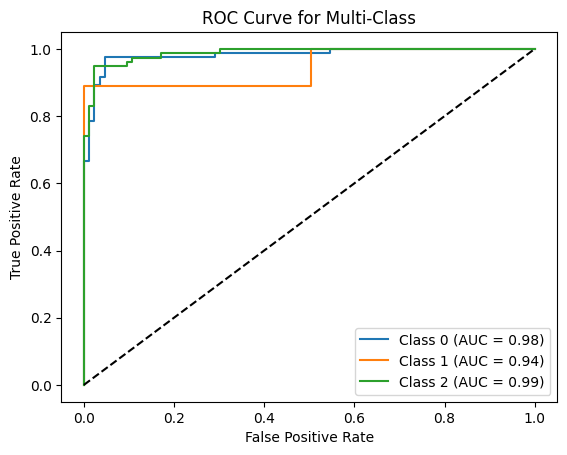

In [29]:
# ROC Curve and AUC (for Multi-Class)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_prob = model.predict(ds_test)

# Compute ROC curve and AUC for each class
for i in range(3):  # Assuming three classes
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()

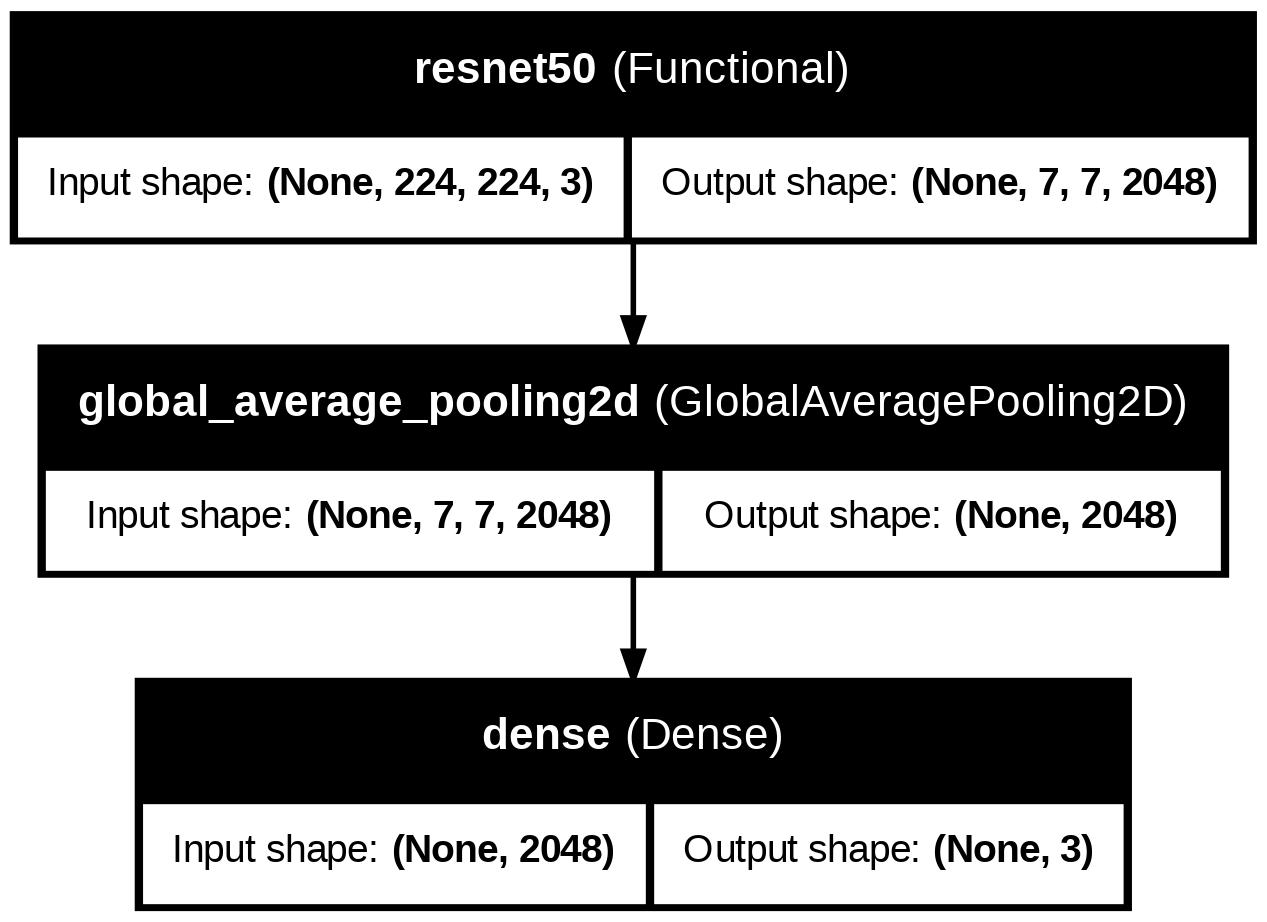

In [30]:
# Model Architecture Visualization
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
# Export Data

df_history.to_csv('/content/model_history_restnet3.csv', index=True)

In [33]:
from google.colab import files
files.download('/content/model_history_restnet3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>